In [11]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from multiprocessing import active_children

In [15]:
def load_dataset(train: bool, transform: v2.Compose, download=False) -> Dataset:
    return torchvision.datasets.CIFAR10(root='./data', train=train, download=download, transform=transform)

basic_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_dataset = load_dataset(train=True, transform=basic_transform)
train_loader = DataLoader(train_dataset, batch_size=16)

In [16]:
img_batch, labels = next(iter(train_loader))

In [17]:
img_batch.shape

torch.Size([16, 3, 32, 32])

In [18]:
import matplotlib.pyplot as plt

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2470, 0.2435, 0.2616])

def unnormalize_batch(batch: torch.Tensor):
    unnormalized = batch.permute(0, 2, 3, 1)*std + mean
    return unnormalized.permute(0, 3, 1, 2)
    

def visualize_patches(sequence_of_patches: torch.Tensor, patch_size: int, nrow: int) -> None:
    sequence_length  = len(sequence_of_patches)
    sequence_of_images = sequence_of_patches.reshape(sequence_length, 3,patch_size, patch_size)
    
    sequence_of_images = unnormalize_batch(sequence_of_images)
    image_grid = torchvision.utils.make_grid(sequence_of_images, nrow=nrow, padding=1, pad_value=1)
    
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

In [33]:
import torch.nn as nn


class Patch(nn.Module):

    def __init__(self, patch_size: int, image_size: int, in_channels: int = 3):
        super().__init__()

        if image_size % patch_size:
            raise AssertionError("Image size should be multiple of patch size")

        self.unfold = nn.Unfold((patch_size, patch_size), stride=patch_size)

        self._patches_per_example = image_size*image_size // (patch_size*patch_size)
        self._patch_vector_size = (patch_size*patch_size*in_channels)

    
    def forward(self, x):
        unfolded = self.unfold(x)
        return unfolded.permute(0, 2, 1)
    
    @property
    def patches_per_example(self):
        return self._patches_per_example
    
    @property
    def patch_vector_size(self):
        return self._patch_vector_size

    
patching = Patch(8, 32)
patching.patches_per_example, patching.patch_vector_size

(16, 192)

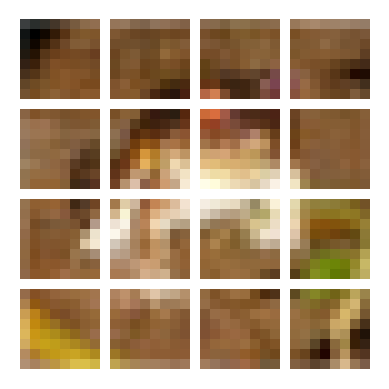

torch.Size([16, 16, 192])

In [36]:
unfolded = patching(img_batch)
visualize_patches(unfolded[0], 8, nrow=4) # visualize fist sequence from batch
unfolded.shape

In [266]:
class Transformer(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_norm1= nn.LayerNorm(256)
        self.layer_norm2= nn.LayerNorm(256)

        self.linear1 = nn.Linear(256, 512)
        self.linear2 = nn.Linear(512, 256)

        self.attention = nn.MultiheadAttention(256, 8)

        self.gelu = nn.GELU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        
        x_residual1 = self.layer_norm1(x)

        x_attention, attention_weights = self.attention(x, x, x)
        x_residual2 = x_residual1 + x_attention

        x = self.layer_norm2(x_residual2)

        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)

        x = self.linear2(x)
        x = self.dropout(x)

        x += x_residual2

        return x

class VIT(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(192, 256)
        self.cls_token = nn.Parameter(torch.randn(1, 1, 256))
        self.pos_encoding = nn.Parameter(torch.randn(1, 17, 256))


        self.transformers = nn.ModuleList([
            Transformer() for _ in range(6)
        ])

        self.dropout = nn.Dropout(0.2)
        self.layer_norm = nn.LayerNorm(256)
        self.linear_decision = nn.Linear(256, 10)


    def forward(self, x):
        x = self.linear(x)
        x = torch.column_stack((self.cls_token.repeat(16, 1, 1), x))
        x = x.reshape(16, 17, 256)
        x += self.pos_encoding
        x = self.dropout(x)

        for transformer in self.transformers:
            x = transformer(x)

        cls_token = x[:, 0, :]

        final = self.layer_norm(cls_token)
        final = self.linear_decision(final)
        return final

In [271]:
vit = VIT().to("mps")
out = vit(unfolded.to("mps"))
out.shape

torch.Size([16, 10])

In [269]:
sum(p.numel() for p in vit.parameters())

3219722